In [51]:
%matplotlib inline
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

In [52]:
# clear_cache('cython')

In [53]:
defaultclock.dt = 0.01*ms

In [54]:
#### Borrowing from input factory of neurodynex package

def get_step_current(t_start, t_end, t_total, unit_time, amplitude):

    I_arr = np.zeros(t_total)*amp
    I_arr[t_start : t_end+1] = amplitude
    t_arr = TimedArray(np.arange(0, t_total), dt = 1*unit_time)
    I_arr = TimedArray(I_arr, dt = 1*unit_time)
    return t_arr, I_arr

In [103]:
def get_ramp_current(t_start, t_end, t_total, unit_time, ramp_height, base_height):

    I_arr = np.zeros(t_total)*amp
    slope = (ramp_height - base_height)/(t_end - t_start)
    t_base = np.arange(0, t_start)
    t_ramp = np.arange(t_start, t_end)
    t_finish = np.arange(t_end, t_total)
    I_arr[: t_start] = base_height
    I_arr[t_start : t_end] = base_height + slope * (t_ramp - t_start)
    I_arr[t_end : ] = base_height

    return TimedArray( np.concatenate([t_base, t_ramp, t_finish]), dt=1*unit_time), TimedArray(I_arr, dt = 1*unit_time)   

In [55]:
# neuron parameters

ps1 = {
    "El" : 10.6 * mV,
    "EK" : -12 * mV,
    "ENa" : 115 * mV,
    "gl" : 0.3 * msiemens,
    "gK" : 36 * msiemens,
    "gNa" : 120 * msiemens,
    "C" : 1 * ufarad
}

In [64]:
def HH(I_arr, duration, params, n_neuron, u_rest, u_fire, u_refrac):
    El = params["El"]
    EK = params["EK"]
    ENa = params["ENa"]
    gl = params["gl"]
    gK = params["gK"]
    gNa = params["gNa"]
    C = params["C"] 

    eqs = ''' 
        I = I_arr(t) : amp
        dm/dt = alpha_m*(1-m) - beta_m*m : 1
        dn/dt = alpha_n*(1-n) - beta_n*n : 1
        dh/dt = alpha_h*(1-h) - beta_h*h : 1
        alpha_m = .1*(25*mV-u)/(exp(2.5-.1*u/mV)-1)/mV/ms : Hz
        beta_m = 4*exp(-.0556*u/mV)/ms : Hz
        alpha_n = .01*(10*mV-u)/(exp(1-.1*u/mV)-1)/mV/ms : Hz
        beta_n = .125*exp(-.0125*u/mV)/ms : Hz
        alpha_h = .07*exp(-.05*u/mV)/ms : Hz
        beta_h = 1./(1+exp(3.-.1*u/mV))/ms : Hz
        I_total = I - gNa*(m**3)*h*(u-ENa) - gK*(n**4)*(u-EK) - gl*(u-El) : amp
        du/dt = I_total/C : volt
    '''

    group = NeuronGroup(
        n_neuron,
        eqs,
        threshold='u > u_fire',
        refractory='u > u_refrac',
        method=exponential_euler
    )

    group.u = u_rest
    group.m = 0.05
    group.h = 0.60
    group.n = 0.32

    statemon = StateMonitor(group, ['u', 'I', 'm', 'n', 'h'], record=True)
    spikemon = SpikeMonitor(group)

    hh_net = Network(group)
    hh_net.add(statemon)
    hh_net.add(spikemon)
    hh_net.run(duration)

    return statemon, spikemon



# 5.1.1 -> single spike

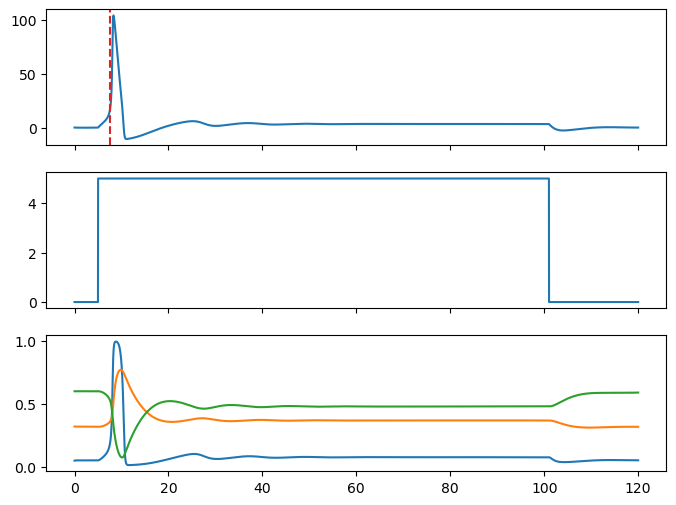

In [83]:
I_amp = 5*uA

t_arr, I_arr = get_step_current(5, 100, 120, ms, I_amp)
statemon, spikemon = HH(I_arr, 120 * ms, ps1, 1, 0*mV, 20*mV, 10*mV)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6), sharex=True)

ax[0].plot(statemon.t/ms, statemon.u[0]/mV)
if spikemon.count > 0:
    for t_spike in spikemon.t/ms : 
        ax[0].axvline(t_spike, ls= "--", color="tab:red")
ax[1].plot(statemon.t/ms, statemon.I[0]/uA)
ax[2].plot(statemon.t/ms, statemon.m[0])
ax[2].plot(statemon.t/ms, statemon.n[0])
ax[2].plot(statemon.t/ms, statemon.h[0])

# 5.1.2 -> Repetitive spiking

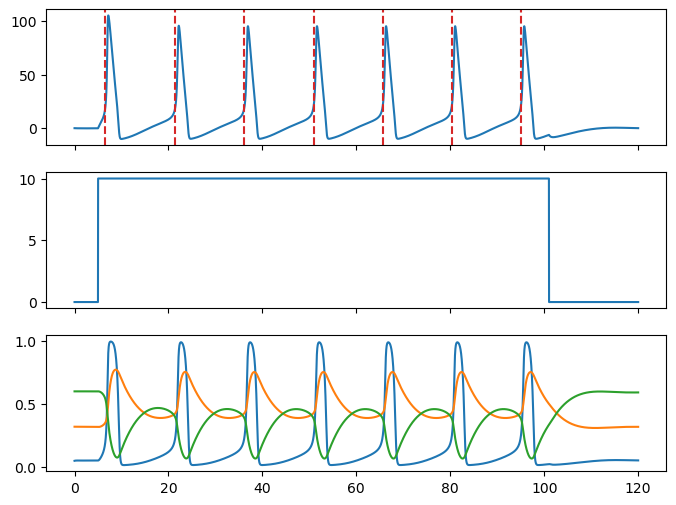

In [84]:
I_amp = 10*uA

t_arr, I_arr = get_step_current(5, 100, 120, ms, I_amp)
statemon, spikemon = HH(I_arr, 120 * ms, ps1, 1, 0*mV, 20*mV, 10*mV)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6), sharex=True)

ax[0].plot(statemon.t/ms, statemon.u[0]/mV)
if spikemon.count > 0:
    for t_spike in spikemon.t/ms : 
        ax[0].axvline(t_spike, ls= "--", color="tab:red")
ax[1].plot(statemon.t/ms, statemon.I[0]/uA)
ax[2].plot(statemon.t/ms, statemon.m[0])
ax[2].plot(statemon.t/ms, statemon.n[0])
ax[2].plot(statemon.t/ms, statemon.h[0])

# 5.2.1 -> slow ramp current

In [110]:
defaultclock.dt = 0.01*ms

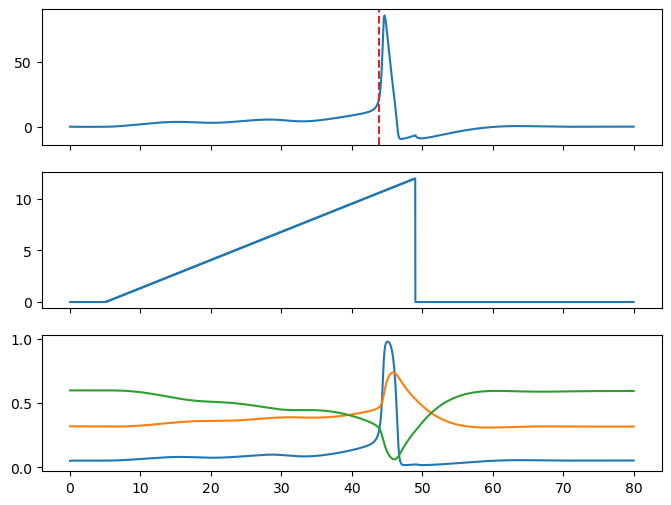

In [122]:
t_arr, I_arr = get_ramp_current(50, 490, 800, 0.1*ms, 12*uA, 0*uA)
statemon, spikemon = HH(I_arr, 80 * ms, ps1, 1, 0*mV, 20*mV, 10*mV)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6), sharex=True)

ax[0].plot(statemon.t/ms, statemon.u[0]/mV)
if spikemon.count > 0:
    for t_spike in spikemon.t/ms : 
        ax[0].axvline(t_spike, ls= "--", color="tab:red")
ax[1].plot(statemon.t/ms, statemon.I[0]/uA)
ax[2].plot(statemon.t/ms, statemon.m[0])
ax[2].plot(statemon.t/ms, statemon.n[0])
ax[2].plot(statemon.t/ms, statemon.h[0])

# 5.2.2 -> Fast ramp

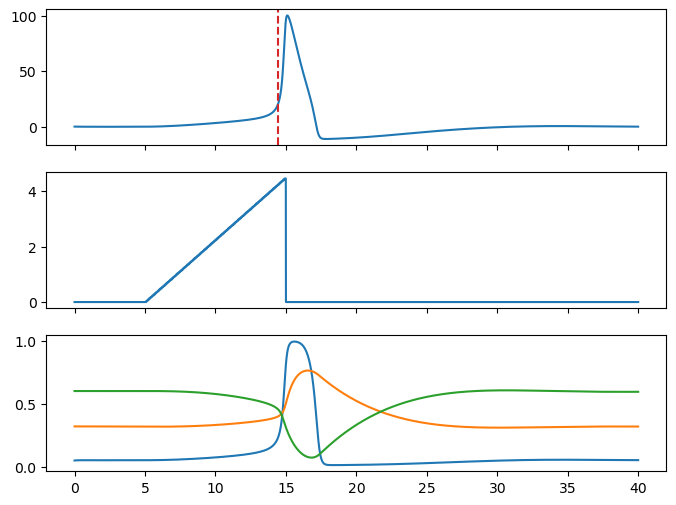

In [123]:
t_arr, I_arr = get_ramp_current(50, 150, 400, 0.1*ms, 4.5*uA, 0*uA)
statemon, spikemon = HH(I_arr, 40 * ms, ps1, 1, 0*mV, 20*mV, 10*mV)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6), sharex=True)

ax[0].plot(statemon.t/ms, statemon.u[0]/mV)
if spikemon.count > 0:
    for t_spike in spikemon.t/ms : 
        ax[0].axvline(t_spike, ls= "--", color="tab:red")
ax[1].plot(statemon.t/ms, statemon.I[0]/uA)
ax[2].plot(statemon.t/ms, statemon.m[0])
ax[2].plot(statemon.t/ms, statemon.n[0])
ax[2].plot(statemon.t/ms, statemon.h[0])

# 5.3.1 -> Rebound spike

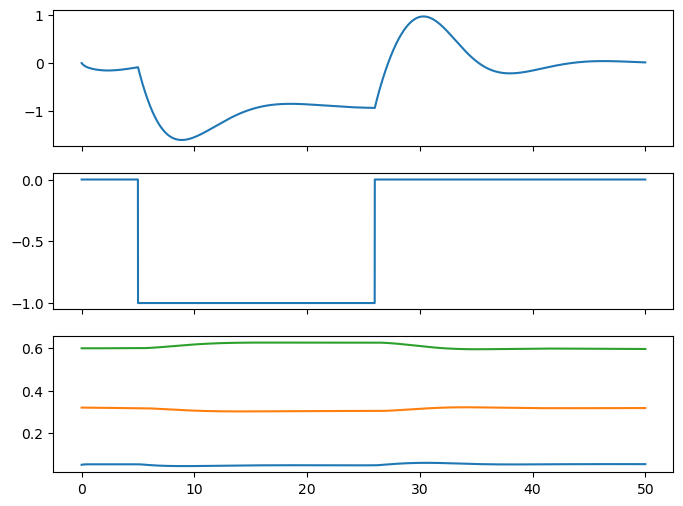

In [125]:
I_amp = -1*uA

t_arr, I_arr = get_step_current(5, 25, 50, ms, I_amp)
statemon, spikemon = HH(I_arr, 50 * ms, ps1, 1, 0*mV, 20*mV, 10*mV)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6), sharex=True)

ax[0].plot(statemon.t/ms, statemon.u[0]/mV)
if spikemon.count > 0:
    for t_spike in spikemon.t/ms : 
        ax[0].axvline(t_spike, ls= "--", color="tab:red")
ax[1].plot(statemon.t/ms, statemon.I[0]/uA)
ax[2].plot(statemon.t/ms, statemon.m[0])
ax[2].plot(statemon.t/ms, statemon.n[0])
ax[2].plot(statemon.t/ms, statemon.h[0])

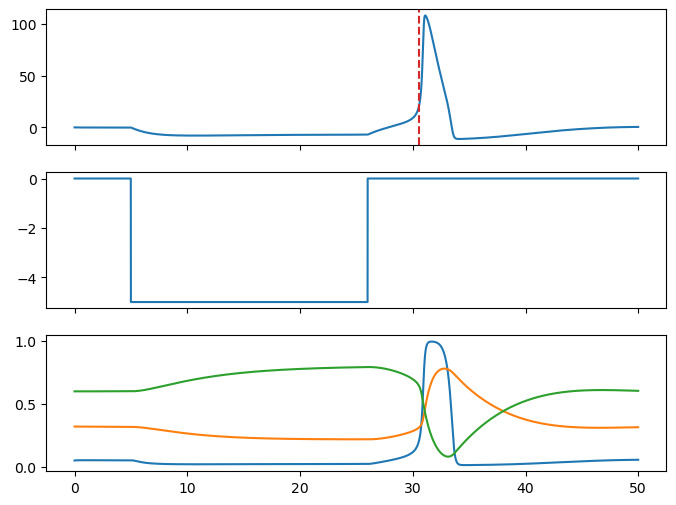

In [126]:
I_amp = -5*uA

t_arr, I_arr = get_step_current(5, 25, 50, ms, I_amp)
statemon, spikemon = HH(I_arr, 50 * ms, ps1, 1, 0*mV, 20*mV, 10*mV)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6), sharex=True)

ax[0].plot(statemon.t/ms, statemon.u[0]/mV)
if spikemon.count > 0:
    for t_spike in spikemon.t/ms : 
        ax[0].axvline(t_spike, ls= "--", color="tab:red")
ax[1].plot(statemon.t/ms, statemon.I[0]/uA)
ax[2].plot(statemon.t/ms, statemon.m[0])
ax[2].plot(statemon.t/ms, statemon.n[0])
ax[2].plot(statemon.t/ms, statemon.h[0])

# 5.4.1

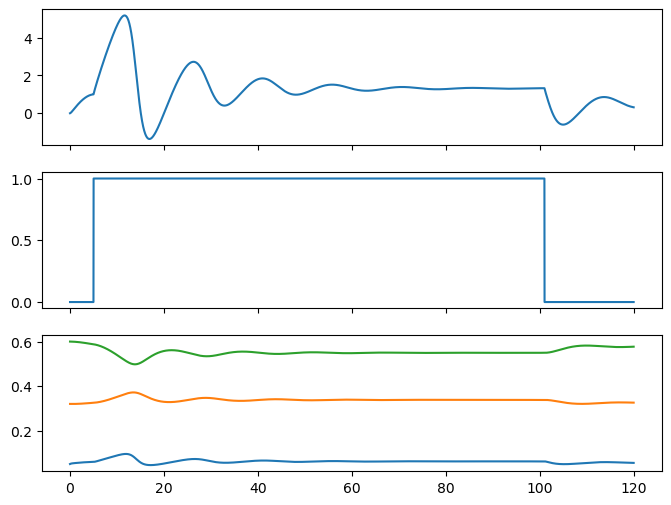

In [130]:
# neuron parameters

ps2 = {
    "El" : 10.6 * mV,
    "EK" : -12 * mV,
    "ENa" : 115 * mV,
    "gl" : 0.3 * msiemens,
    "gK" : 36 * msiemens,
    "gNa" : 1.4*120 * msiemens,
    "C" : 1 * ufarad
}

I_amp = 1*uA

t_arr, I_arr = get_step_current(5, 100, 120, ms, I_amp)
statemon, spikemon = HH(I_arr, 120 * ms, ps2, 1, 0*mV, 20*mV, 10*mV)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6), sharex=True)

ax[0].plot(statemon.t/ms, statemon.u[0]/mV)
if spikemon.count > 0:
    for t_spike in spikemon.t/ms : 
        ax[0].axvline(t_spike, ls= "--", color="tab:red")
ax[1].plot(statemon.t/ms, statemon.I[0]/uA)
ax[2].plot(statemon.t/ms, statemon.m[0])
ax[2].plot(statemon.t/ms, statemon.n[0])
ax[2].plot(statemon.t/ms, statemon.h[0])



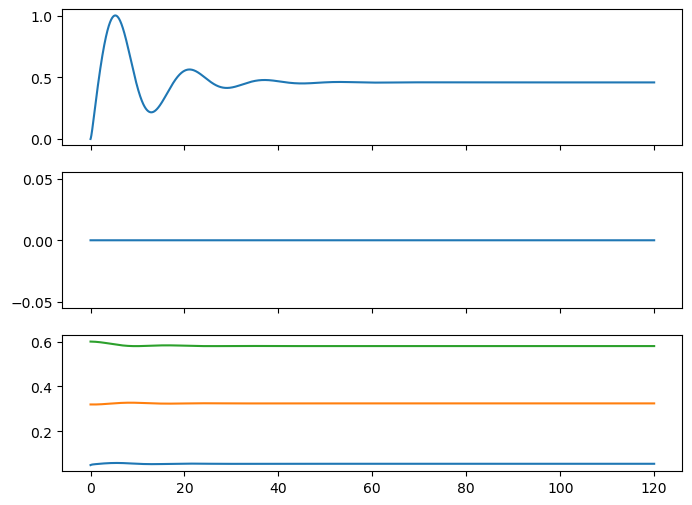

In [131]:
I_amp = 0*uA

t_arr, I_arr = get_step_current(5, 100, 120, ms, I_amp)
statemon, spikemon = HH(I_arr, 120 * ms, ps2, 1, 0*mV, 20*mV, 10*mV)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6), sharex=True)

ax[0].plot(statemon.t/ms, statemon.u[0]/mV)
if spikemon.count > 0:
    for t_spike in spikemon.t/ms : 
        ax[0].axvline(t_spike, ls= "--", color="tab:red")
ax[1].plot(statemon.t/ms, statemon.I[0]/uA)
ax[2].plot(statemon.t/ms, statemon.m[0])
ax[2].plot(statemon.t/ms, statemon.n[0])
ax[2].plot(statemon.t/ms, statemon.h[0])

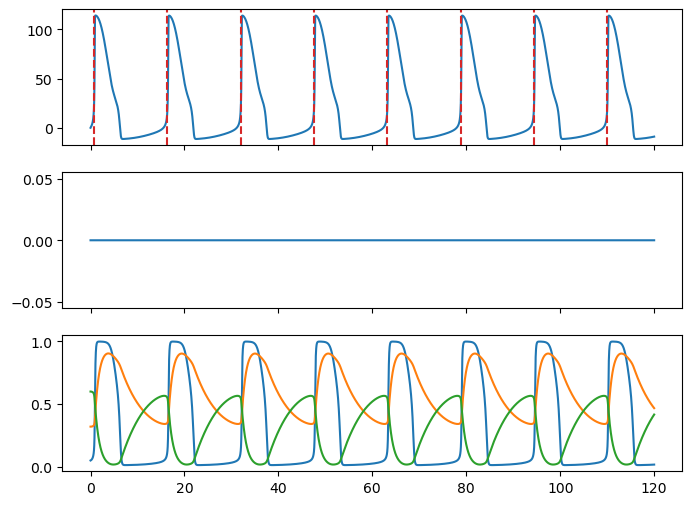

In [138]:
ps3 = {
    "El" : 10.6 * mV,
    "EK" : -12 * mV,
    "ENa" : 115 * mV,
    "gl" : 0.3 * msiemens,
    "gK" : 36 * msiemens,
    "gNa" : 10*120 * msiemens,
    "C" : 1 * ufarad
}

I_amp = 0*uA

t_arr, I_arr = get_step_current(5, 100, 120, ms, I_amp)
statemon, spikemon = HH(I_arr, 120 * ms, ps3, 1, 0*mV, 20*mV, 10*mV)
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(8,6), sharex=True)

ax[0].plot(statemon.t/ms, statemon.u[0]/mV)
if spikemon.count > 0:
    for t_spike in spikemon.t/ms : 
        ax[0].axvline(t_spike, ls= "--", color="tab:red")
ax[1].plot(statemon.t/ms, statemon.I[0]/uA)
ax[2].plot(statemon.t/ms, statemon.m[0])
ax[2].plot(statemon.t/ms, statemon.n[0])
ax[2].plot(statemon.t/ms, statemon.h[0])